In [1]:
import numpy as np
import pandas as pd

from itertools import chain
from matplotlib import pyplot as plt

from parse_input_file import parse_file
from create_feature_dfs import compose_signals_df, create_initial_input
from LeastSquaresMethod import LeastSquaresMethod
from RecursiveLeastSquaresMethod import RecursiveLeastSquaresMethod
from metrics import compose_all_metrics
from ploting_utils import plot_one_model_metric, plot_two_models_metric

In [2]:
READ_FROM_FILE = True

In [32]:
if READ_FROM_FILE:
    parsing_result = parse_file('Test+')
    
    a_coefs = [parsing_result['out_weights'][i] for i in parsing_result['out_weights'].keys()]
    b_coefs = [parsing_result['manage_weights'][i] for i in parsing_result['manage_weights'].keys()]
else:
    a_coefs = [0,0.15,-0.33,0.25]
    b_coefs = [1,0.3,0.7,0.]

    parsing_result = create_initial_input(a_coefs, b_coefs, uniform_low=0, uniform_high=100, time_series_shape=1000, noise_std=2)

In [4]:
features_dfs = compose_signals_df(parsing_result)

features_dfs.head()

,y(k),y(k-1),y(k-2),y(k-3),v(k),v(k-1),v(k-2),v(k-3)
0,-0.129424,0.012543,-0.330653,-0.263688,0.789293,0.294494,-1.258052,-0.178062
1,-0.097545,-0.129424,0.012543,-0.330653,0.267935,0.789293,0.294494,-1.258052
2,-0.027886,-0.097545,-0.129424,0.012543,0.463723,0.267935,0.789293,0.294494
3,-0.046153,-0.027886,-0.097545,-0.129424,0.984378,0.463723,0.267935,0.789293
4,-0.026714,-0.046153,-0.027886,-0.097545,-0.551910,0.984378,0.463723,0.267935


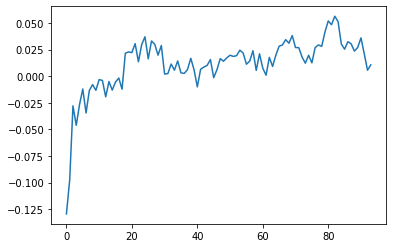

In [5]:
features_dfs['''y(k)'''].plot()

# Least Square Method

In [6]:
best_ls_method = LeastSquaresMethod(biased=True)

In [8]:
best_ls_method.fit(X=np.array(features_dfs.drop(columns=['''y(k)'''])), 
                   y=np.array(features_dfs['''y(k)''']))

In [10]:
ls_pred = best_ls_method.predict(np.array(features_dfs.drop(columns=['''y(k)'''])))

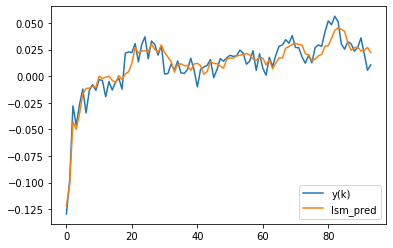

In [11]:
features_dfs['lsm_pred'] = ls_pred
features_dfs[['''y(k)''','lsm_pred']].plot();
features_dfs.drop(columns='lsm_pred', inplace=True)

In [12]:
compose_all_metrics(features_dfs['''y(k)'''], ls_pred, best_ls_method.coef_matrix.shape[0])

{'rmse': 8.956252605170549e-05,
 'determination_coef': 0.8691696792706486,
 'akke_coef': -433.0642052474828}

## Different LS Models

In [13]:
ls_models = []

for y_idx in range(3,0,-1):
    for v_idx in range(3,0, -1):
        print('-'*5 + 'NEW MODEL' + '-'*5)
        coefs_to_ignore = ['''y(k-{})'''.format(i) for i in range(1,y_idx)] + ['''v(k-{})'''.format(i) for i in range(1,v_idx)]
        left_coefs = (set(features_dfs.columns) - {'''y(k)'''}) - set(coefs_to_ignore)
        print('Left coefs: {}'.format(left_coefs))
        print('Model R({},{})'.format(4-y_idx, 4-v_idx))
        
        ls_method = LeastSquaresMethod(biased=True)
        ls_method.fit(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                      y=np.array(features_dfs['''y(k)''']))
        ls_pred = ls_method.predict(np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)))
        
        temp_results = compose_all_metrics(features_dfs['''y(k)'''], ls_pred, ls_method.coef_matrix.shape[0])
        
        print('Metrics: {}'.format(temp_results))
        
        temp_results['name'] = 'R({},{})'.format(4-y_idx, 4-v_idx)
        
        ls_models.append(temp_results)
        

-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'v(k-3)'}
Model R(1,1)
Metrics: {'rmse': 0.00016109603850967302, 'determination_coef': 0.764675614728856, 'akke_coef': -385.8802171506004}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'v(k-2)', 'v(k-3)'}
Model R(1,2)
Metrics: {'rmse': 0.00016050374896216767, 'determination_coef': 0.7655408139911007, 'akke_coef': -384.2264566854622}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'v(k-3)', 'v(k-1)', 'v(k-2)'}
Model R(1,3)
Metrics: {'rmse': 0.00015935111766055896, 'determination_coef': 0.7672245441126162, 'akke_coef': -382.90393777241815}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'y(k-2)', 'v(k-3)'}
Model R(2,1)
Metrics: {'rmse': 0.00011406598503659064, 'determination_coef': 0.8333757424614043, 'akke_coef': -416.3312357920438}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'v(k-3)', 'v(k-2)', 'y(k-2)'}
Model R(2,2)
Metrics: {'rmse': 0.000113865580754827, 'determination_coef': 0.8336684871796987, 'akke_coef': -414.49

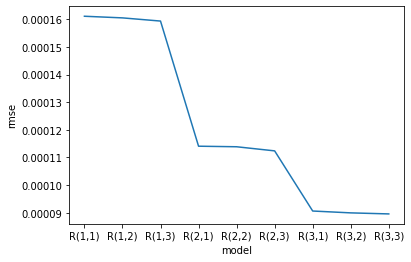

In [14]:
plot_one_model_metric(ls_models, 'rmse')

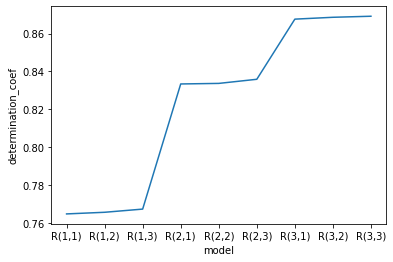

In [15]:
plot_one_model_metric(ls_models, 'determination_coef')

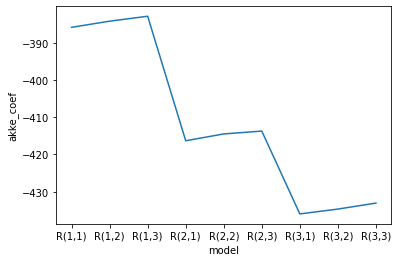

In [16]:
plot_one_model_metric(ls_models, 'akke_coef')

# Recursive Least Square Method

In [19]:
best_rls_method = RecursiveLeastSquaresMethod(coef_matrix_shape=features_dfs.shape[1] - 1, 
                                              biased=True)

In [20]:
rls_pred, rls_coefs = best_rls_method.predict_all(X=np.array(features_dfs.drop(columns=['''y(k)'''])), 
                                                  y=np.array(features_dfs['''y(k)''']))

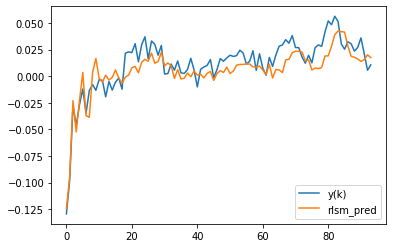

In [21]:
features_dfs['rlsm_pred'] = rls_pred
features_dfs[['''y(k)''','rlsm_pred']].plot();
features_dfs.drop(columns='rlsm_pred', inplace=True)

In [22]:
compose_all_metrics(features_dfs['''y(k)'''], rls_pred, best_rls_method.coef_matrix.shape[0])

{'rmse': 0.00017012595541348886,
 'determination_coef': 0.7320748511311039,
 'akke_coef': -372.7536096861132}

In [23]:
rls_models = []

for y_idx in range(3,0,-1):
    for v_idx in range(3,0, -1):
        print('-'*5 + 'NEW MODEL' + '-'*5)
        coefs_to_ignore = ['''y(k-{})'''.format(i) for i in range(1,y_idx)] + ['''v(k-{})'''.format(i) for i in range(1,v_idx)]
        left_coefs = (set(features_dfs.columns) - {'''y(k)'''}) - set(coefs_to_ignore)
        print('Left coefs: {}'.format(left_coefs))
        print('Model R({},{})'.format(4-y_idx, 4-v_idx))
        
        rls_method = RecursiveLeastSquaresMethod(coef_matrix_shape=features_dfs.shape[1] - len(coefs_to_ignore) - 1, 
                                                 biased=True)
        rls_pred, _ = rls_method.predict_all(X=np.array(features_dfs.drop(columns=['''y(k)'''] + coefs_to_ignore)), 
                                                     y=np.array(features_dfs['''y(k)''']))
        
        temp_results = compose_all_metrics(features_dfs['''y(k)'''], rls_pred, rls_method.coef_matrix.shape[0])
        
        print('Metrics: {}'.format(temp_results))
        
        temp_results['name'] = 'R({},{})'.format(4-y_idx, 4-v_idx)
        
        rls_models.append(temp_results)

-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'v(k-3)'}
Model R(1,1)
Metrics: {'rmse': 0.00029487422049994966, 'determination_coef': 0.6035530072542513, 'akke_coef': -329.0526868575315}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'v(k-2)', 'v(k-3)'}
Model R(1,2)
Metrics: {'rmse': 0.0002784345202265075, 'determination_coef': 0.6155885642863173, 'akke_coef': -332.4450888263023}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'v(k-3)', 'v(k-1)', 'v(k-2)'}
Model R(1,3)
Metrics: {'rmse': 0.00025125102338528624, 'determination_coef': 0.6868602591563211, 'akke_coef': -340.10174485647707}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'y(k-2)', 'v(k-3)'}
Model R(2,1)
Metrics: {'rmse': 0.00023091781171508986, 'determination_coef': 0.6172389746023932, 'akke_coef': -350.03446866077604}
-----NEW MODEL-----
Left coefs: {'y(k-3)', 'v(k)', 'v(k-3)', 'v(k-2)', 'y(k-2)'}
Model R(2,2)
Metrics: {'rmse': 0.0002202183869383333, 'determination_coef': 0.6282665933347794, 'akke_coef': -352.

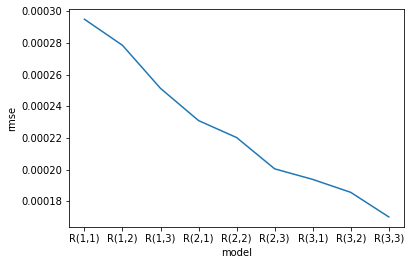

In [24]:
plot_one_model_metric(rls_models, 'rmse')

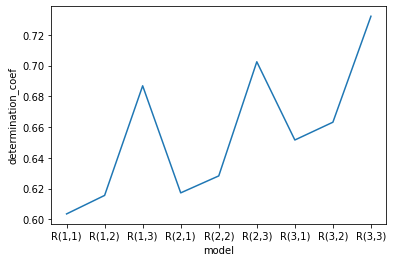

In [25]:
plot_one_model_metric(rls_models, 'determination_coef')

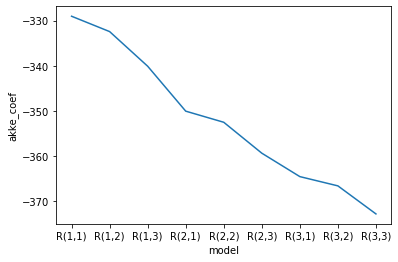

In [26]:
plot_one_model_metric(rls_models, 'akke_coef')

# Compare models

## Metrics

In [27]:
models_dict = {'ls_method':ls_models, 'rls_method':rls_models}

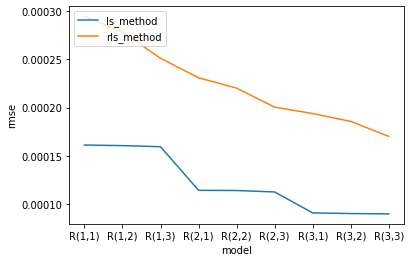

In [28]:
plot_two_models_metric(models_dict, 'rmse')

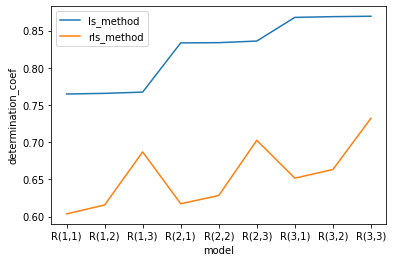

In [29]:
plot_two_models_metric(models_dict, 'determination_coef')

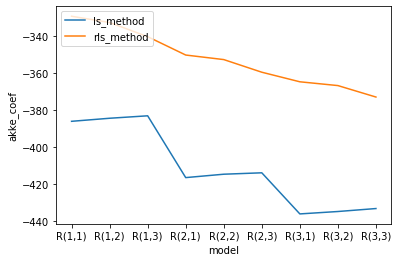

In [30]:
plot_two_models_metric(models_dict, 'akke_coef')

## Coefficients

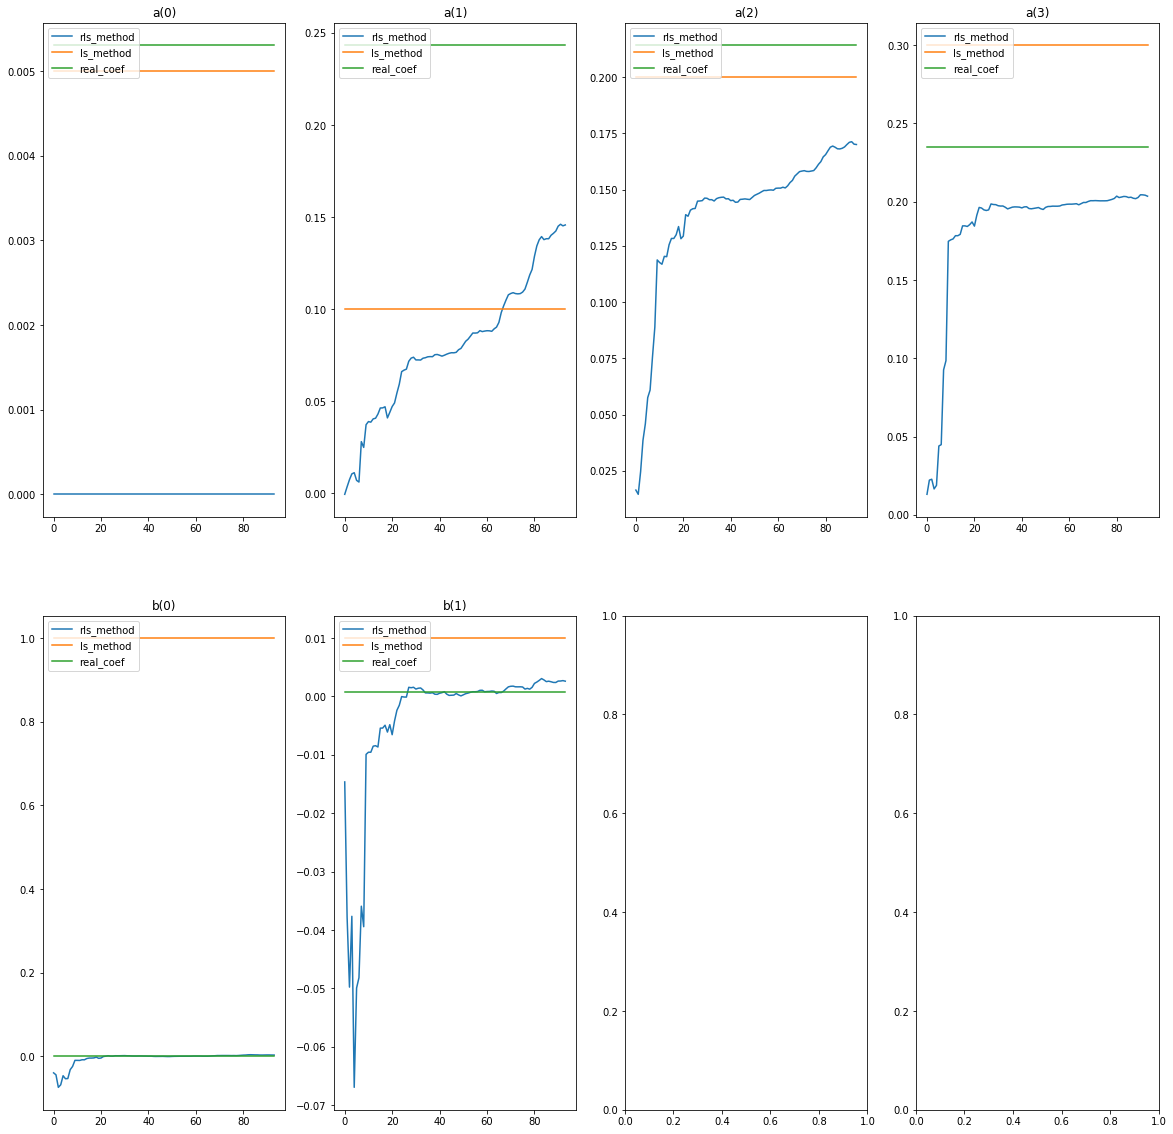

In [33]:
plt.rcParams["figure.figsize"] = (20,20)

fig, axs = plt.subplots(2, 4)

for i in range(len(a_coefs)):
    axs[0,i].set_title('''a({})'''.format(i))
    axs[0,i].plot(np.array(rls_coefs)[:,i])
    axs[0,i].plot([a_coefs[i] for j in range(rls_coefs.shape[0])])
    axs[0,i].plot([best_ls_method.coef_matrix[i] for j in range(rls_coefs.shape[0])])
    axs[0,i].legend(['rls_method','ls_method','real_coef'], loc='upper left')
    

for i in range(len(b_coefs)):
    axs[1,i].set_title('''b({})'''.format(i))
    axs[1,i].plot(np.array(rls_coefs)[:,i+len(a_coefs)])
    axs[1,i].plot([b_coefs[i] for j in range(rls_coefs.shape[0])])
    axs[1,i].plot([best_ls_method.coef_matrix[i+len(a_coefs)] for j in range(rls_coefs.shape[0])])
    axs[1,i].legend(['rls_method','ls_method','real_coef'], loc='upper left')